# **Import Package**

코드에서 필요한 모듈과 패키지를 가져오는 부분.

In [ ]:
import numpy as np

**Numpy**

: 코드에서 이미지를 numpy 배열로 바꾸어 다루게 된다. numpy 배열을 생성하고 그를 다루는 다양한 메소드를 사용.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

**Matplotlib, Seaborn**

: 데이터, 이미지를 시각화 하는데 사용.

In [ ]:
import keras.layers as layers
import keras.optimizers as optimizers
from keras.models import Model, load_model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, ModelCheckpoint, ReduceLROnPlateau

**Keras**

: 모델을 만들고 이를 학습시키고 그 과정에서 여러 파라메터를 설정하는데 사용.   
to_categorical의 경우 데이터 전처리에 사용.

In [ ]:
import matplotlib.patches as patches
from PIL import Image
from skimage.transform import resize

완성된 모델의 평가, 모델을 사용한 결과물의 작성에 사용되는 모듈들.

In [ ]:
import threading, random, os

각각 쓰레드 관리, 랜덤값 생성, test 이미지를 가져오기 위한 경로 설정에 사용.

# **Data Generator**

원본 이미지와 라벨 데이터를 가져오고, 이 이미지와 라벨을 패널로 나누어 학습 데이터와 라벨을 생성하는 커스텀 생성기를 작성하는 부분.

## **Load Dataset**

원본 이미지와 라벨 데이터를 가져온다. 코드를 실행하기 전에 코드와 같은 폴더에 데이터셋을 다운받는다.   

https://www.kaggle.com/kairess/find-waldo

In [ ]:
imgs = np.load('dataset/imgs_uint8.npy').astype(np.float32) / 255.
labels = np.load('dataset/labels_uint8.npy').astype(np.float32) / 255.
waldo_sub_imgs = np.load('dataset/waldo_sub_imgs_uint8.npy') / 255.
waldo_sub_labels = np.load('dataset/waldo_sub_labels_uint8.npy') / 255.

원본 코드 작성시와 numpy 버전 차이가 있어 waldo_sub_imgs와 waldo_sub_labels를 로드할 때 오류가 발생한다. allow_pickle 파라메터의 기본값이 True에서 False로 바뀌어 발생하는 문제로 ```allow_pickle=True```를 코드에 추가해주면 해결된다.

pickle은 파이썬에서 제공하는 모듈로 자료형의 변화 없이 데이터를 저장하고 불러올 수 있게해준다. 다만 악의적으로 제작된 데이터를 불러올 경우 임의로 코드를 실행하는 문제가 있을 수 있기 때문에 보안상의 문제로 기본값이 변경된 것으로 보인다.

In [ ]:
imgs = np.load('dataset/imgs_uint8.npy').astype(np.float32) / 255.
labels = np.load('dataset/labels_uint8.npy').astype(np.float32) / 255.
waldo_sub_imgs = np.load('dataset/waldo_sub_imgs_uint8.npy', allow_pickle=True) / 255.
waldo_sub_labels = np.load('dataset/waldo_sub_labels_uint8.npy', allow_pickle=True) / 255.

In [ ]:
print(imgs.shape, labels.shape)

(18, 1760, 2800, 3) (18, 1760, 2800)


먼저 imgs와 labels의 형태를 확인한다.   
imgs는 1760*2800 크기의 이미지 18장으로 RGB 데이터값이 입력된 numpy배열이다.
labels는 똑같은 이미지에서 waldo가 있는 부분을 255, 아닌 부분을 0으로 표시한 numpy배열이다.

데이터를 학습에 적합한 형태로 (0과 1사이의 값으로) 바꾸기 위해 255로 나눠준다.


In [ ]:
print(waldo_sub_imgs.shape, waldo_sub_labels.shape)
print(waldo_sub_imgs[0].shape, waldo_sub_imgs[1].shape)

(18,) (18,)
(379, 397, 3) (386, 394, 3)


다음으로 waldo_sub_imgs와 waldo_sub_labels의 형태를 확인한다.
waldo_sub_imgs는 imgs에서 waldo가 있는 부분과 그 주변을 잘라낸 이미지로 imgs와 마찬가지로 RGB 데이터값을 가진 이미지 18장의 numpy배열이다.   
자른 크기는 각각 다름을 확인할 수 있다.
waldo_sub_labels는 labels와 동일하게 waldo_sub_imgs와 동일한 크기인 waldo가 있는 부분을 255, 아닌 부분을 0으로 표시한 numpy 배열이다.

역시 데이터를 학습에 적합한 형태로 바꾸기 위해 255로 나눠준다.

## **Data Generator**

이 코드에서는 이미지를 패널로 나누어 모델 학습을 진행한다.   
학습을 위해 이미지와 라벨을 패널로 분할해 데이터를 만드는 생성기를 작성한다.

In [ ]:
class BatchIndices(object):
    def __init__(self, n, bs, shuffle=False):
        self.n,self.bs,self.shuffle = n,bs,shuffle
        self.lock = threading.Lock()
        self.reset()

    def reset(self):
        self.idxs = (np.random.permutation(self.n) 
                     if self.shuffle else np.arange(0, self.n))
        self.curr = 0

    def __next__(self):
        with self.lock:
            if self.curr >= self.n: self.reset()
            ni = min(self.bs, self.n-self.curr)
            res = self.idxs[self.curr:self.curr+ni]
            self.curr += ni
            return res
        
class segm_generator(object):
    def __init__(self, x, y, bs=64, out_sz=(224,224), train=True, waldo=True):
        self.x, self.y, self.bs, self.train = x,y,bs,train
        self.waldo = waldo
        self.n = x.shape[0]
        self.ri, self.ci = [], []
        for i in range(self.n):
            ri, ci, _ = x[i].shape
            self.ri.append(ri), self.ci.append(ci) 
        self.idx_gen = BatchIndices(self.n, bs, train)
        self.ro, self.co = out_sz
        
    def get_slice(self, i,o):
        start = random.randint(0, i-o) if self.train else (i-o)
        return slice(start, start+o)

    def get_item(self, idx):
        slice_r = self.get_slice(self.ri[idx], self.ro)
        slice_c = self.get_slice(self.ci[idx], self.co)
        x = self.x[idx][slice_r, slice_c]
        y = self.y[idx][slice_r, slice_c]
        if self.train and (random.random()>0.5): 
            y = y[:,::-1]
            x = x[:,::-1]
        if not self.waldo and np.sum(y)!=0:
            return None

        return x, to_categorical(y, num_classes=2).reshape((y.shape[0] * y.shape[1], 2))

    def __next__(self):
        idxs = self.idx_gen.__next__()
        items = []
        for idx in idxs:
            item = self.get_item(idx)
            if item is not None:
                items.append(item)
        if not items:
            return None
        xs,ys = zip(*tuple(items))
        return np.stack(xs), np.stack(ys)
        
def seg_gen_mix(x1, y1, x2, y2, tot_bs=4, prop=0.34, out_sz=(224,224), train=True):
    n1 = int(tot_bs*prop)
    n2 = tot_bs - n1
    sg1 = segm_generator(x1, y1, n1, out_sz = out_sz ,train=train)
    sg2 = segm_generator(x2, y2, n2, out_sz = out_sz ,train=train, waldo=False)
    while True:
        out1 = sg1.__next__()
        out2 = sg2.__next__()
        if out2 is None:
            yield out1
        else:
            yield np.concatenate((out1[0], out2[0])), np.concatenate((out1[1], out2[1]))            

```seg_gen_mix```라는 함수를 만들기 위해 ```BatchIndice```와 ```segm_generator```라는 클래스를 설정한다. 각각의 변수가 어떤 의미를 가지는지 이해하는 것이 중요하다.

변수 확인을 위해 ```seg_gen_mix``` 함수의 파라메터를 먼저 확인한다.   
x1, y1은 위에서 가져온 waldo_sub_imgs와 waldo_sub_labels, x2, y2는 imgs와 labels가 들어간다.   
tot_bs와 prop는 한번의 batch에서 생성할 패널의 최대 개수와 그 중 x1과 y1을 이용해 생성할 패널의 비율을 설정하는 파라메터이다.   
out_sz는 생성할 패널의 크기를 지정한다.   
train은 추가적인 옵션을 바꾸기 위해 설정한 boolean값이다.

이제 함수에서 사용되는 ```segm_generator``` instance 생성 부분 파라메터값을 보면 이미지와 라벨, tot_bs와 prop를 활용하여 만든 생성할 이미지의 개수, 패널의 크기, train 옵션, waldo 옵션이 들어가는걸 볼 수 있다. imgs와 labels를 이용한 instance 생성에는 waldo가 False로 설정되어있다.

```segm_generator``` 클래스를 설정하는 부분에서 ```BatchIndice instance```를 생성하는 부분을 보면 self.n, bs, train 값을 전달하는걸 확인할 수 있다. bs와 train은 앞서 전달받은 생성할 이미지의 개수와 train 옵션의 값이고 self.n의 경우 들어온 이미지의 0번 인덱스 즉 입력된 데이터의 이미지 개수(이 경우에는 18장)이다.

In [ ]:
# class BatchIndices(object):
#     def __init__(self, n, bs, shuffle=False):
#         self.n,self.bs,self.shuffle = n,bs,shuffle
#         self.lock = threading.Lock()
#         self.reset()

#     def reset(self):
#         self.idxs = (np.random.permutation(self.n) 
#                      if self.shuffle else np.arange(0, self.n))
#         self.curr = 0

#     def __next__(self):
#         with self.lock:
#             if self.curr >= self.n: self.reset()
#             ni = min(self.bs, self.n-self.curr)
#             res = self.idxs[self.curr:self.curr+ni]
#             self.curr += ni
#             return res

```BatchIndice```는 한 batch에서 생성할 패널을 추출할 원본 이미지의 인덱스를 설정하는 클래스이다. ```__init__```, ```reset```, ```__next__``` 세가지 메소드가 설정되어있다.

```__init__```은 instance를 만들 때 실행되는 메소드로, instance 설정시 입력된 파라메터 값을 속성값으로 저장하는 부분이다. 이후 바로 ```reset```을 실행한다.

```reset```에서는 idxs와 curr을 설정한다. idxs는 원본 이미지의 인덱스 번호 순서 배열이다. shuffle이 False일 경우 앞에서부터 순서대로 (0~17) 생성이 되고 True일 경우 이 순서를 섞어주게 된다. curr은 아래 ```__next__```부분을 보면 정확히 알 수 있는데 한 batch가 끝난 뒤 다음 생성을 시작할 idxs의 인덱스값이다.

```__next__```는 위에서 설정된 값을 바탕으로 패널을 생성할 원본 이미지의 인덱스 번호 배열을 돌려준다. curr값이 이미지 전체 개수보다 클 경우 다시 ```reset```을 실행하여 curr값과 idxs를 초기화 한다. ni는 추출할 원본 이미지의 개수인데 기본적으로 설정된 bs(batch size)를 따라가지만 남은 이미지 개수가 이보다 적을 경우 남은 이미지 개수로 설정된다. res에서 설정된 ni값과 curr값을 이용해 idxs에서 인덱스 값을 slicing 한다. slicing이 끝나면 curr값에 ni값을 더해주고 slicing한 인덱스 배열을 돌려준다.

- np.random.permutation(num),   
: 랜덤으로 섞인 배열을 돌려준다. 숫자가 입력된 경우 0에서 해당 숫자 전까지의 배열을, 배열이 입력된 경우 해당 배열을 섞는다.

In [ ]:
# class segm_generator(object):
#     def __init__(self, x, y, bs=64, out_sz=(224,224), train=True, waldo=True):
#         self.x, self.y, self.bs, self.train = x,y,bs,train
#         self.waldo = waldo
#         self.n = x.shape[0]
#         self.ri, self.ci = [], []
#         for i in range(self.n):
#             ri, ci, _ = x[i].shape
#             self.ri.append(ri), self.ci.append(ci) 
#         self.idx_gen = BatchIndices(self.n, bs, train)
#         self.ro, self.co = out_sz
        
#     def get_slice(self, i,o):
#         start = random.randint(0, i-o) if self.train else (i-o)
#         return slice(start, start+o)

#     def get_item(self, idx):
#         slice_r = self.get_slice(self.ri[idx], self.ro)
#         slice_c = self.get_slice(self.ci[idx], self.co)
#         x = self.x[idx][slice_r, slice_c]
#         y = self.y[idx][slice_r, slice_c]
#         if self.train and (random.random()>0.5): 
#             y = y[:,::-1]
#             x = x[:,::-1]
#         if not self.waldo and np.sum(y)!=0:
#             return None

#         return x, to_categorical(y, num_classes=2).reshape((y.shape[0] * y.shape[1], 2))

#     def __next__(self):
#         idxs = self.idx_gen.__next__()
#         items = []
#         for idx in idxs:
#             item = self.get_item(idx)
#             if item is not None:
#                 items.append(item)
#         if not items:
#             return None
#         xs,ys = zip(*tuple(items))
#         return np.stack(xs), np.stack(ys)

```segm_generator```는 이미지를 자르기 위한 값들을 설정하고 이에 따라 패널을 생성하는 메소드가 설정된 클래스이다. ```__init___```, ```get_slice```, ```get_item```, ```__next__``` 네가지 메소드가 설정되어있다.

```__init__```은 필요한 속성값을 저장하는 부분이다. 파라메터에서 지정된 값 이외의 값들을 살펴보면 n에는 이미지의 전체 개수(18장), ri와 ci는 각각 이미지의 세로와 가로 크기(imgs의 경우 1760, 2800, sub_imgs의 경우 각각 다르다)의 배열이다. idx_gen은 위에서 생성한 ```BatchIndices``` instance로 각각의 파라메터는 처음에 알아보았다. ro와 co는 생성할 패널의 세로와 가로 크기이다.
원본 코드에서는 ych가 설정되어있었으나 해당 코드에서는 사용하지 않는 부분이라 삭제하였다.

```get_slice```는 이미지를 slicing 하기 위한 slice 객체를 만드는 메소드이다. 전체 길이 i와 패널의 길이 o를 받아 0과 i-o 사이의 랜덤값을 slice 시작점, 시작점에서 o를 더한 값을 끝점으로 잡는 slice 객체를 생성한다.

```get_item```은 패널을 생성하는 메소드이다. 위에서 생성한 ```get_slice``` 메소드와 ```__init__```에서 저장한 속성값을 이용한다. ```get_slice```를 사용해 가로와 세로의 슬라이스 객체를 만들고 이를 사용해 입력된 idx의 이미지를 slicing한다. 50%의 확률로 이미지를 좌우 반전한다. waldo를 False로 설정했을 때 생성한 패널에 waldo가 있는 부분이 있으면(```np.sum(y)!=0```) None값을 그 이외의 경우에는 slicing한 x와 y패널을 돌려주는데 여기서 y를 ```to_categorical```패키지를 사용해 인코딩 해주고 2차원 데이터로 reshape 한다.

```__next__```는 입력된 batch_size만큼 이미지와 라벨 패널을 생성해 그 패널들을 저장한 배열을 돌려주는 함수이다. 먼저 생성한 ```BatchIndices```클래스의 instance에 ```__next__``` 메소드를 사용해 bs만큼 패널을 추출해낼 원본 이미지의 인덱스 번호 배열을 만든다. 그 후 생성한 배열을 이용해 위에서 만든 ```get_item```메소드를 반복문을 돌려 각 이미지에서 패널을 생성, items에 저장한다. 이 때 waldo=False가 설정되어있을 경우 패널들 중 waldo가 포함된 패널이 하나도 없으면 None값이 반환된다. items는 각각의 패널이 ```[[x1,y1],[x2,y2]...]```의 형태로 들어가 있기 때문에 zip과 stack을 사용해 ```[x1,x2...] [y1,y2...]``` 형태로 바꾸어 이 두 배열을 돌려준다.

- _:   
여러가지 용도가 있지만 이 코드에서는 3개의 값을 받지만 마지막 값을 사용하지 않을 때, 해당 값을 무시하기 위해서 사용되었다.

- random.randint(a, b):   
a에서 b사이의 임의의 정수를 돌려준다. a와 b를 모두 포함한다.

- if not list:   
list가 boolean값으로 사용될 수 있다. len(list) == 0 일 경우 False, 그 외의 경우 True 값을 가진다.

- zip(a, b, c...):   
a, b, c가 iterable 객체여야한다. a, b, c에서 각각 값을 가져와 새로운 list로 엮어준다. 예를들어 ```zip('abc', '123')```의 경우 ```[('a','1'),('b','2'),('c','3')]```이 반환된다.

- *:
여러가지 용도가 있지만 iterable 객체 앞에 사용되면 그 안의 값을 차례로 넘겨준다. 예를 들어 ```print(list)```를 하면 list 전체를 출력하겠지만 ```print(*list)```를 하면 list 안의 요소를 하나하나 출력해준다.

- np.stack():   
배열의 모양이 모두 같아야 사용할 수 있다. 배열을 합쳐 새로운 배열을 만든다.


In [ ]:
# def seg_gen_mix(x1, y1, x2, y2, tot_bs=4, prop=0.34, out_sz=(224,224), train=True):
#     n1 = int(tot_bs*prop)
#     n2 = tot_bs - n1
#     sg1 = segm_generator(x1, y1, n1, out_sz = out_sz ,train=train)
#     sg2 = segm_generator(x2, y2, n2, out_sz = out_sz ,train=train, waldo=False)
#     while True:
#         out1 = sg1.__next__()
#         out2 = sg2.__next__()
#         if out2 is None:
#             yield out1
#         else:
#             yield np.concatenate((out1[0], out2[0])), np.concatenate((out1[1], out2[1]))


```seg_gen_mix```는 위에서 작성한 클래스들을 활용해 실제로 학습데이터와 라벨을 만들어내는 생성기이다.
n1은 waldo_sub_imgs를 사용해 만들 패널의 수, n2는 imgs를 사용해 만들 패널의 수를 의미한다. 각각의 이미지와 bs를 적용해 ```segm_generator```클래스 instance를 만들고 ```__next__``` 메소드를 이용해 패널을 만든다. sg2의 경우 waldo가 False로 지정되어있기 때문에 항상 waldo가 없는 패널을 생성한다. 

- yield:   
return과 달리 값을 바로 반환하지 않고 next()를 실행하면 값을 넘겨준다. generator에 많이 사용한다.

- np.concatenate():   
두 배열을 합친다. axis를 지정할 수 있다.

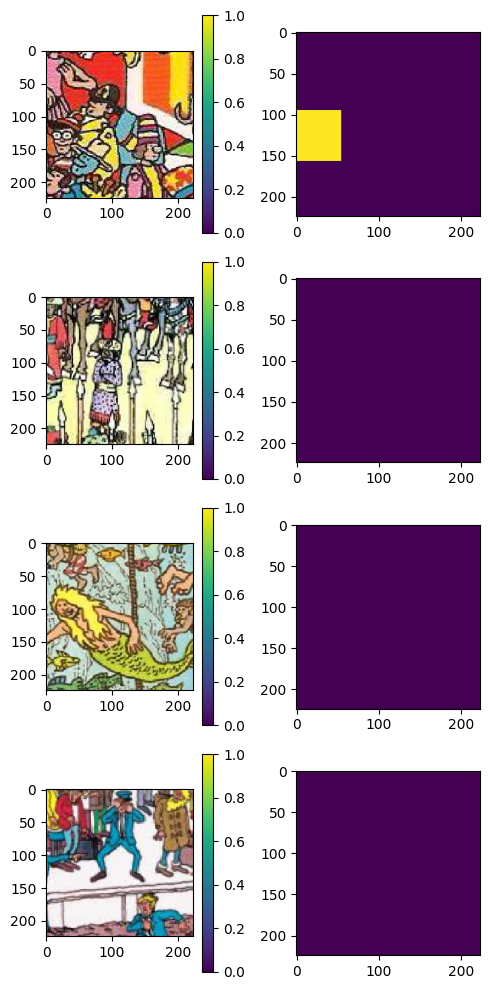

In [ ]:
PANNEL_SIZE = 224

gen_mix = seg_gen_mix(waldo_sub_imgs, waldo_sub_labels, imgs, labels, tot_bs=4, prop=0.34, out_sz=(PANNEL_SIZE, PANNEL_SIZE))

X, y = next(gen_mix)

plt.figure(figsize=(5, 10))
for i, img in enumerate(X):
    plt.subplot(X.shape[0], 2, 2*i+1)
    plt.imshow(X[i])
    plt.subplot(X.shape[0], 2, 2*i+2)
    plt.colorbar()
    plt.imshow(y[i][:,1].reshape((PANNEL_SIZE, PANNEL_SIZE)))
    plt.tight_layout()

작성한 생성기를 이용해 Sample 패널을 만들어 본다.   
label 데이터의 경우 reshape를 했기 때문에 시각화를 위해 다시 reshape 해준다.

# Create Model

이제 CNN 신경망을 만들 것이다.

In [ ]:
#신경망 구성
inputs = layers.Input(shape=(PANNEL_SIZE, PANNEL_SIZE, 3))

net = layers.Conv2D(64, kernel_size=3, padding='same')(inputs)
# net = layers.Activation('relu')(net)
net = layers.LeakyReLU()(net)
net = layers.MaxPool2D(pool_size=2)(net) 

shortcut_1 = net

net = layers.Conv2D(128, kernel_size=3, padding='same')(net)
# net = layers.Activation('relu')(net)
net = layers.LeakyReLU()(net)
net = layers.MaxPool2D(pool_size=2)(net)

shortcut_2 = net

net = layers.Conv2D(256, kernel_size=3, padding='same')(net)
# net = layers.Activation('relu')(net)
net = layers.LeakyReLU()(net)
net = layers.MaxPool2D(pool_size=2)(net)

shortcut_3 = net

net = layers.Conv2D(256, kernel_size=1, padding='same')(net)
# net = layers.Activation('relu')(net)
net = layers.LeakyReLU()(net)
net = layers.MaxPool2D(pool_size=2)(net)

net = layers.UpSampling2D(size=2)(net)
net = layers.Conv2D(256, kernel_size=3, padding='same')(net)
net = layers.Activation('relu')(net)

net = layers.Add()([net, shortcut_3])

net = layers.UpSampling2D(size=2)(net)
net = layers.Conv2D(128, kernel_size=3, padding='same')(net)
net = layers.Activation('relu')(net)

net = layers.Add()([net, shortcut_2])

net = layers.UpSampling2D(size=2)(net)
net = layers.Conv2D(64, kernel_size=3, padding='same')(net)
net = layers.Activation('relu')(net)

net = layers.Add()([net, shortcut_1])

net = layers.UpSampling2D(size=2)(net)
net = layers.Conv2D(2, kernel_size=1, padding='same')(net)

net = layers.Reshape((-1, 2))(net)
net = layers.Activation('softmax')(net)

model = Model(inputs=inputs, outputs=net)

model.compile(
    loss='categorical_crossentropy', 
    optimizer=optimizers.Adam(), 
    metrics=['acc'],
    sample_weight_mode='temporal'
)

model.summary()

NameError: name 'layers' is not defined

대략적인 과정은 이러하다.<br>
신경망은 DownSampling을 4번, UpSampling을 4번한 구조이다.<br>
MaxPool2D로 DownSampling을 하고 해당 층의 모델을 shortcut에 저장해둔다. 이 과정을 4번 반복하여 size를 축소시킨다. <br>
그 후에 UpSampling을 4번하고, 채널을 2개로 만들어준다. 그 후 두 채널을 더하여 1이 되는 값을 나오게 한다.

In [ ]:
#inputs = layers.Input(shape=(PANNEL_SIZE, PANNEL_SIZE, 3))

input 데이터는 224,224,3로, 224*224 사이즈의 컬러 이미지 3채널이다.

In [ ]:
# net = layers.Conv2D(64, kernel_size=3, padding='same')(inputs)
# # net = layers.Activation('relu')(net)
# net = layers.LeakyReLU()(net)
# net = layers.MaxPool2D(pool_size=2)(net) 

MaxPool2D를 이용해 DownSampling을 하는 과정이다.
input 데이터가 처음으로 들어가게 되는데, Conv2D를 통해서 데이터의 특징을 뽑아낸다. 합성곱을 사용하여 특징을 뽑아내는데, 필터를 통해 필터의 값과 합성곱을 하여 필요없는 값들을 작게 만들고, 중요한 값들은 값을 늘려 필요한 값은 커지고, 필요없는 값들은 작아지게 만든다.
* 64는 필터의 수
* kernel_size는 커널의 행과 열 (아래 사진은 kernel_size=5)
* padding은 합성곱을 하기 전에 주변을 특정값으로 채워넣는 것으로, 경계를 처리하기 위해 사용된다. padding에 따라 사이즈가 변경된다.

<img src = "https://blog.kakaocdn.net/dn/7xpIJ/btrxiXZwws7/QQckg2sKVSwApKcEDdChi0/img.gif" width = "300" height = "300">

                Conv2D
<img src = "https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F9916C23F5BC97EEE31" width = "300" height = "300">


              padding

신경망에서 노드에 들어오는 값들은 Activation function(활성화 함수)을 통과하여 다음 층에 들어갈 지 말지 결정한다. <br> 흔히 사용하는 ReLU를 사용하지 않고, LeakyReLU를 사용하는 이유는 ReLU는 x가 음수일 때 기울기가 0이 된다. 음수의 값들은 모델에 영향을 주지 않아 정보가 손실된다.<br>하지만 LeakyReLU는 x가 음수일 때 기울기를 0.01정도 주어 음수값도 미미하지만 영향을 주게되어 ReLU의 단점을 보완했다.

MaxPooling2D는 input size를 줄이는 과정으로, MaxPooling2D는 큰 값만 뽑아서 pool_size로 축소시킨다. 사진과 같이 2x2사이즈의 크기에서 가장 큰 값들만 뽑아서 2x2사이즈로 사이즈를 줄인다.<br>큰 값들만 추출하고 작은 값은 없앴기에 특징을 더 잘 뽑아낸다. 이로 인해 Overfitting(과적합)을 줄일 수 있다.

![alt text](./images/maxpooling2d.png)

이렇게 한 차례의 DownSampling을 하고 shortcut에 해당 모델을 저장하는데, 이는<span style="color: #2D3748; background-color:#fff5b1;">  **skip connection**  </span>을 사용하기 위해 저장하는 것이다.<br>
**skip connection**은 이를 사용하는 UpSampling과정에서 설명하겠다.

In [ ]:
# net = layers.UpSampling2D(size=2)(net)
# net = layers.Conv2D(256, kernel_size=3, padding='same')(net)
# net = layers.Activation('relu')(net)

DownSampling을 4번한 후에 UpSampling을 한다.<br>
UpSampling을 하는 이유는 DownSampling을 하면서 압축된 이미지를 원본 크기로 되돌리기 위함이다.<br>
UpSampling2D를 사용하면 사이즈를 2배씩 늘리는데, 해당 코드는 2X2사이즈로 4X4로 늘린다.

In [ ]:
# net = layers.Add()([net, shortcut_3])

shortcut을 UpSampling 모델을 만든 후에 넣는데, 그 이유는 skip connection을 사용하기 위해서이다.<br>
신경망 모델은 층이 깊을 수록 좋은 성능을 보여준다. 하지만 층이 너무 깊으면 오히려 성능이 저하되는데, 이를 해결하기 위해 skip connection을 사용한다.

사진과 같이 일반적인 구조에서는 입력 x를 받아 2개의 weighted layer를 거쳐 H(x)가 출력된다.<br>
skip connection을 적용한 구조 Residual 구조는 weighted layer를 거친 값 F(x)와, 입력 값 x를 더한다.<br>
더하는 것의 의미는 기존에 학습한 정보는 보존하고 새로운 학습 정보를 더하는 의미이다. 즉 해당 층에서는 추가적으로 학습해야 할 정보만 학습하게 만드는 것이다.

해당 코드에서는 인풋값 대신에 같은 크기의 UpSampling한 모델을 넣는다.

![skipconnect](https://gaussian37.github.io/assets/img/dl/concept/resnet/2.png "일반적인 모델과, skipconnect을 적용한 모델")

![alt text](./images/plain1.png)
![alt text](./images/skipconnection1.png)

                        plain model                                                 skip connection model

시간상 epochs를 50으로 주었다.

직접 실행했을 때, 학습할 때마다 다르지만 대체적으로 사진과 같이 skip connection을 적용한 모델이 적용하지 않은 모델보다 정확도가 향상된다.

In [ ]:
# net = layers.Reshape((-1, 2))(net)
# net = layers.Activation('softmax')(net)

4번의 UpSampling 과정을 끝내면 원본 이미지의 사이즈로 돌아오게 된다.<br>
Reshape로 sample_weights에서 정의한 output형태로 모양을 변경해준다. (224*224,2)
softmax를 통해 두 채널을 합쳐서 1이 나오게한다.

In [ ]:
# model.compile(
#     loss='categorical_crossentropy', 
#     optimizer=optimizers.Adam(), 
#     metrics=['acc'],
#     sample_weight_mode='temporal'
# )

모델을 compile한다.

loss는 손실함수를 지정하는 것으로, categorical_crossentropy로 설정 (softmax에 주로 쓰임)<br>
optimizer는 Adam으로 설정<br>
metrics는 acc로, 학습과정에서 정확도를 수집한다.<br>
sample_weight_mode='temporal'은 손실 함수에 가중치를 적용하는데 사용된다.
